# Task 6 — Web Scraping & Analysis of Job Postings

**Offline, reproducible pipeline:** scrape a static HTML snapshot, clean and analyze the data, and visualize insights.


## 1. Imports & Settings

In [1]:

import os, json, random, textwrap, zipfile, io, datetime as dt
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# Inline plotting
%matplotlib inline

base_dir = "/mnt/data/task6_webscraping_project"
site_dir = os.path.join(base_dir, "static_job_site")
plots_dir = os.path.join(base_dir, "plots")
pages = [os.path.join(site_dir, f"page{i}.html") for i in range(1,4)]
today = dt.date.today()
print("Pages:", pages)


Pages: ['/mnt/data/task6_webscraping_project\\static_job_site\\page1.html', '/mnt/data/task6_webscraping_project\\static_job_site\\page2.html', '/mnt/data/task6_webscraping_project\\static_job_site\\page3.html']


### Code Explanation

This block sets up the environment and configuration for the job postings web scraping project:

- **Imports**:  
  - `os, json, random, textwrap, zipfile, io, datetime`: system utilities, randomness, file handling, and date operations.  
  - `pandas` and `numpy`: data manipulation and analysis.  
  - `BeautifulSoup`: HTML parsing and scraping.  
  - `matplotlib.pyplot`: data visualization.  

- **%matplotlib inline**: Ensures that plots are displayed inline within a Jupyter Notebook.  

- **Base directories**:  
  - `base_dir`: root folder for the project files.  
  - `site_dir`: location of the static HTML job site to scrape.  
  - `plots_dir`: folder for saving generated charts.  

- **Pages list**: Builds a list of paths to the 3 static HTML job board pages (`page1.html`, `page2.html`, `page3.html`).  

- **today**: Captures the current date, used later for parsing relative posted-date strings (e.g., “5 days ago”).  

- **print**: Confirms that the `pages` list was correctly constructed.


## 2. Scrape Static HTML with BeautifulSoup

In [2]:

def parse_posted_date(text):
    text = text.strip().lower()
    if text == "just posted":
        return today
    if "30+ days" in text:
        return today - dt.timedelta(days=30)
    if "day" in text:
        try:
            n = int(''.join([c for c in text if c.isdigit()]))
            return today - dt.timedelta(days=n)
        except:
            return pd.NaT
    return pd.NaT

synonym_map = {
    "PowerBI": "Power BI",
    "MS Excel": "Excel",
    "Py": "Python",
    "K8s": "Kubernetes",
    "G Cloud": "GCP",
    "ML": "Machine Learning",
    "DL": "Deep Learning"
}

skill_vocab = [
    "Python", "SQL", "Power BI", "Tableau", "Excel", "Pandas", "NumPy",
    "Statistics", "Machine Learning", "Deep Learning", "NLP", "Docker",
    "Kubernetes", "Git", "REST API", "Spark", "Hadoop", "AWS", "Azure", "GCP",
    "ETL", "Data Visualization", "Matplotlib"
]

def normalize_skill(s):
    s0 = s.strip()
    if s0 in synonym_map:
        s0 = synonym_map[s0]
    return s0

records = []
for p in pages:
    with open(p, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f.read(), "html.parser")
    for card in soup.select(".job-card"):
        title = (card.select_one(".title") or {}).get_text(strip=True) if card.select_one(".title") else None
        company = (card.select_one(".company") or {}).get_text(strip=True) if card.select_one(".company") else None
        location = (card.select_one(".location") or {}).get_text(strip=True) if card.select_one(".location") else None
        posted_raw = (card.select_one(".posted") or {}).get_text(strip=True) if card.select_one(".posted") else None
        skills_elems = card.select(".skills .skill")
        skills_list = [normalize_skill(e.get_text(strip=True)) for e in skills_elems]
        desc = (card.select_one(".description") or {}).get_text(" ", strip=True) if card.select_one(".description") else ""
        for k, v in synonym_map.items():
            desc = desc.replace(k, v)
        found_extra = [kw for kw in skill_vocab if kw.lower() in desc.lower()]
        skills_all = sorted(set(skills_list + found_extra))
        posted_dt = parse_posted_date(posted_raw) if posted_raw else pd.NaT
        records.append({
            "title": title, "company": company, "location": location,
            "skills": skills_all, "posted_text": posted_raw, "posted_date": posted_dt
        })

raw_df = pd.DataFrame(records)
raw_df.head()


,title,company,location,skills,posted_text,posted_date
0,Analytics Engineer,Delta Data Labs,"Dhaka, Bangladesh","[AWS, Azure, Data Visualization, ETL, Excel, G...",Posted 14 days ago,2025-08-18
1,Data Analyst,Delta Data Labs,"Rajshahi, Bangladesh","[AWS, Data Visualization, ETL, Git, Matplotlib...",Posted 5 day(s) ago,2025-08-27
2,Machine Learning Engineer,Nile AI,"Dhaka, Bangladesh","[Data Visualization, ETL, Excel, Kubernetes, M...",Posted 12 days ago,2025-08-20
3,Business Intelligence Analyst,Giza Systems,"Khulna, Bangladesh","[AWS, Data Visualization, Deep Learning, ETL, ...",Posted 21 days ago,2025-08-11
4,Data Engineer,BanglaTech,"Chattogram, Bangladesh","[Data Visualization, Deep Learning, ETL, Kuber...",Just posted,2025-09-01


### Scraping Job Cards

- **parse_posted_date()** → converts strings like *“just posted”* or *“5 days ago”* into actual dates.  
- **synonym_map & skill_vocab** → standardize skill names (e.g., *PowerBI → Power BI*, *Py → Python*).  
- **normalize_skill()** → cleans and normalizes skill text.  

From each `.job-card` in the HTML pages, the code extracts:  
- Job **title**, **company**, **location**  
- **Posted date** (raw + parsed)  
- **Skills** (from both `<span class="skill">` and description text)

Finally, all records are combined into a pandas **DataFrame (`raw_df`)** for further cleaning and analysis.  


## 3. Cleaning & Transformation

In [3]:

df = raw_df.copy()
for col in ["title", "company", "location"]:
    df[col] = df[col].fillna("").str.strip()
df["title"] = df["title"].str.title()
df["dup_key"] = df["title"].str.lower() + "|" + df["company"].str.lower() + "|" + df["location"].str.lower()
before = len(df)
df = df.drop_duplicates(subset=["dup_key"]).drop(columns=["dup_key"])
after = len(df)

df["skills"] = df["skills"].apply(lambda x: x if isinstance(x, list) and len(x)>0 else np.nan)
df["skills"] = df["skills"].dropna().apply(lambda lst: sorted(set(lst)))
df["posted_date"] = pd.to_datetime(df["posted_date"])

print("Raw rows:", before, "Clean rows:", len(df), "Duplicates removed:", before - len(df))
df.head()


Raw rows: 129 Clean rows: 103 Duplicates removed: 26


,title,company,location,skills,posted_text,posted_date
0,Analytics Engineer,Delta Data Labs,"Dhaka, Bangladesh","[AWS, Azure, Data Visualization, ETL, Excel, G...",Posted 14 days ago,2025-08-18
1,Data Analyst,Delta Data Labs,"Rajshahi, Bangladesh","[AWS, Data Visualization, ETL, Git, Matplotlib...",Posted 5 day(s) ago,2025-08-27
2,Machine Learning Engineer,Nile AI,"Dhaka, Bangladesh","[Data Visualization, ETL, Excel, Kubernetes, M...",Posted 12 days ago,2025-08-20
3,Business Intelligence Analyst,Giza Systems,"Khulna, Bangladesh","[AWS, Data Visualization, Deep Learning, ETL, ...",Posted 21 days ago,2025-08-11
4,Data Engineer,BanglaTech,"Chattogram, Bangladesh","[Data Visualization, Deep Learning, ETL, Kuber...",Just posted,2025-09-01


### Data Cleaning & Transformation

- **Trim & format text** → remove extra spaces and title-case job titles.  
- **Duplicate removal** → create a composite key (`title+company+location`) to drop repeated postings.  
- **Skills cleanup** → ensure skills are lists, drop empty ones, and deduplicate within each job.  
- **Posted date** → convert relative dates into proper datetime format.  

This step reduces noise and prepares the dataset for reliable analysis.  


## 4. Analysis — Titles, Locations, Skills

In [4]:
exploded = df.explode("skills").dropna(subset=["skills"]).copy()
top_titles = df["title"].value_counts().head(10)
top_locations = df["location"].value_counts().head(10)
top_skills = exploded["skills"].value_counts().head(25)

top_titles


Data Scientist                   18
Business Intelligence Analyst    17
Business Analyst                 17
Data Analyst                     15
Machine Learning Engineer        15
Analytics Engineer               12
Data Engineer                     9
Name: title, dtype: int64

### Analysis — Top Titles, Locations, and Skills

- **Explode skills** → flatten the list of skills so each skill gets its own row.  
- **Top job titles** → count frequency of roles across postings.  
- **Top locations** → identify cities/regions with the most postings.  
- **Top skills** → find the most frequently requested skills across all jobs.  

This helps reveal the **most in-demand roles, locations, and skillsets**.  


In [5]:

top_locations


Khulna, Bangladesh        16
Dhaka, Bangladesh         12
Chattogram, Bangladesh    12
Remote                    12
Gurgaon, India            12
Barishal, Bangladesh      11
Cairo, Egypt              11
Sylhet, Bangladesh         9
Rajshahi, Bangladesh       8
Name: location, dtype: int64

In [6]:

top_skills


Data Visualization    103
ETL                   103
Python                 55
Machine Learning       46
Excel                  44
Power BI               43
Deep Learning          41
REST API               38
Kubernetes             37
GCP                    37
Git                    36
AWS                    35
Matplotlib             35
Tableau                31
Azure                  30
NLP                    29
Statistics             29
NumPy                  28
Spark                  25
SQL                    24
Hadoop                 23
Docker                 23
Pandas                 20
Name: skills, dtype: int64

## 5. Visualizations (matplotlib)

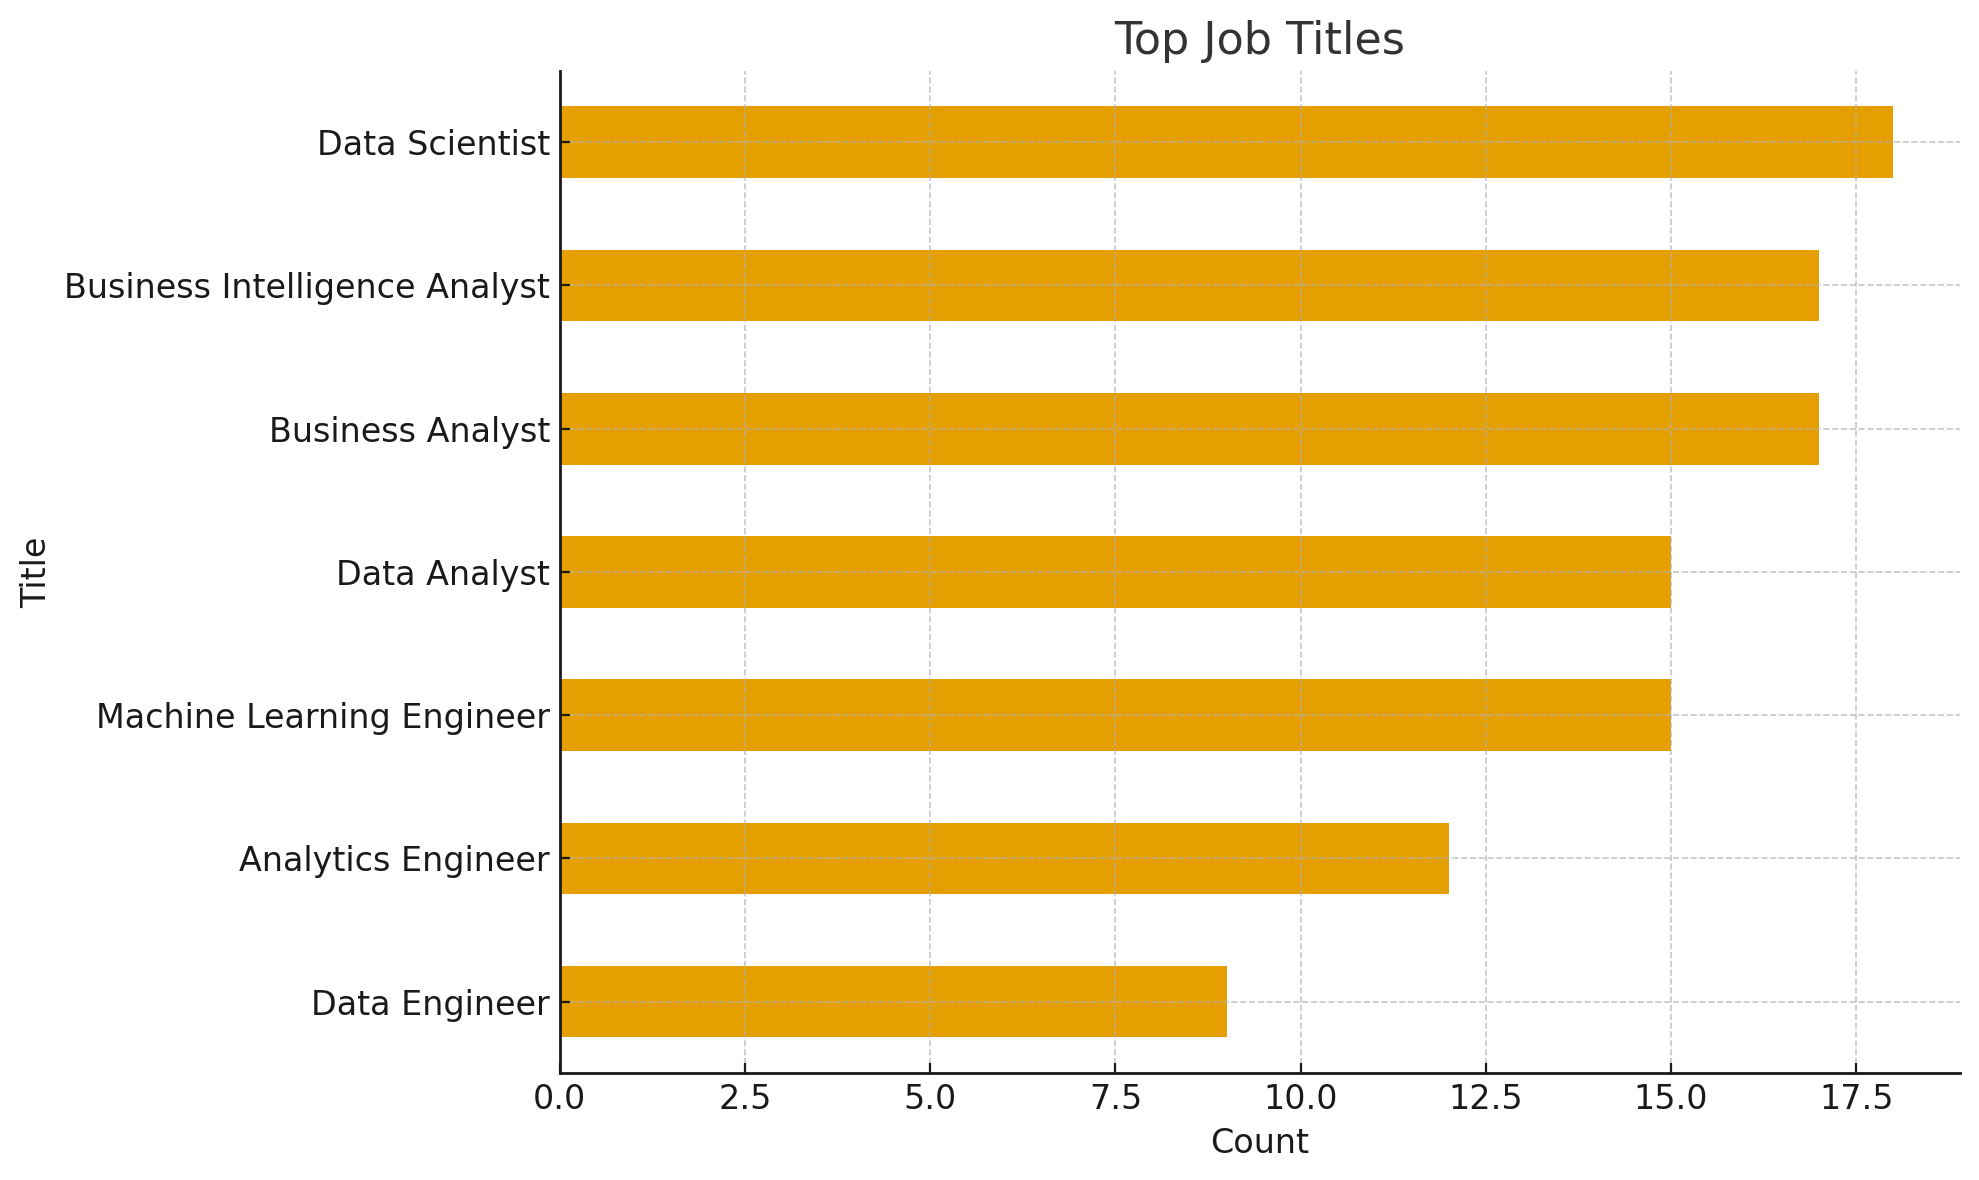

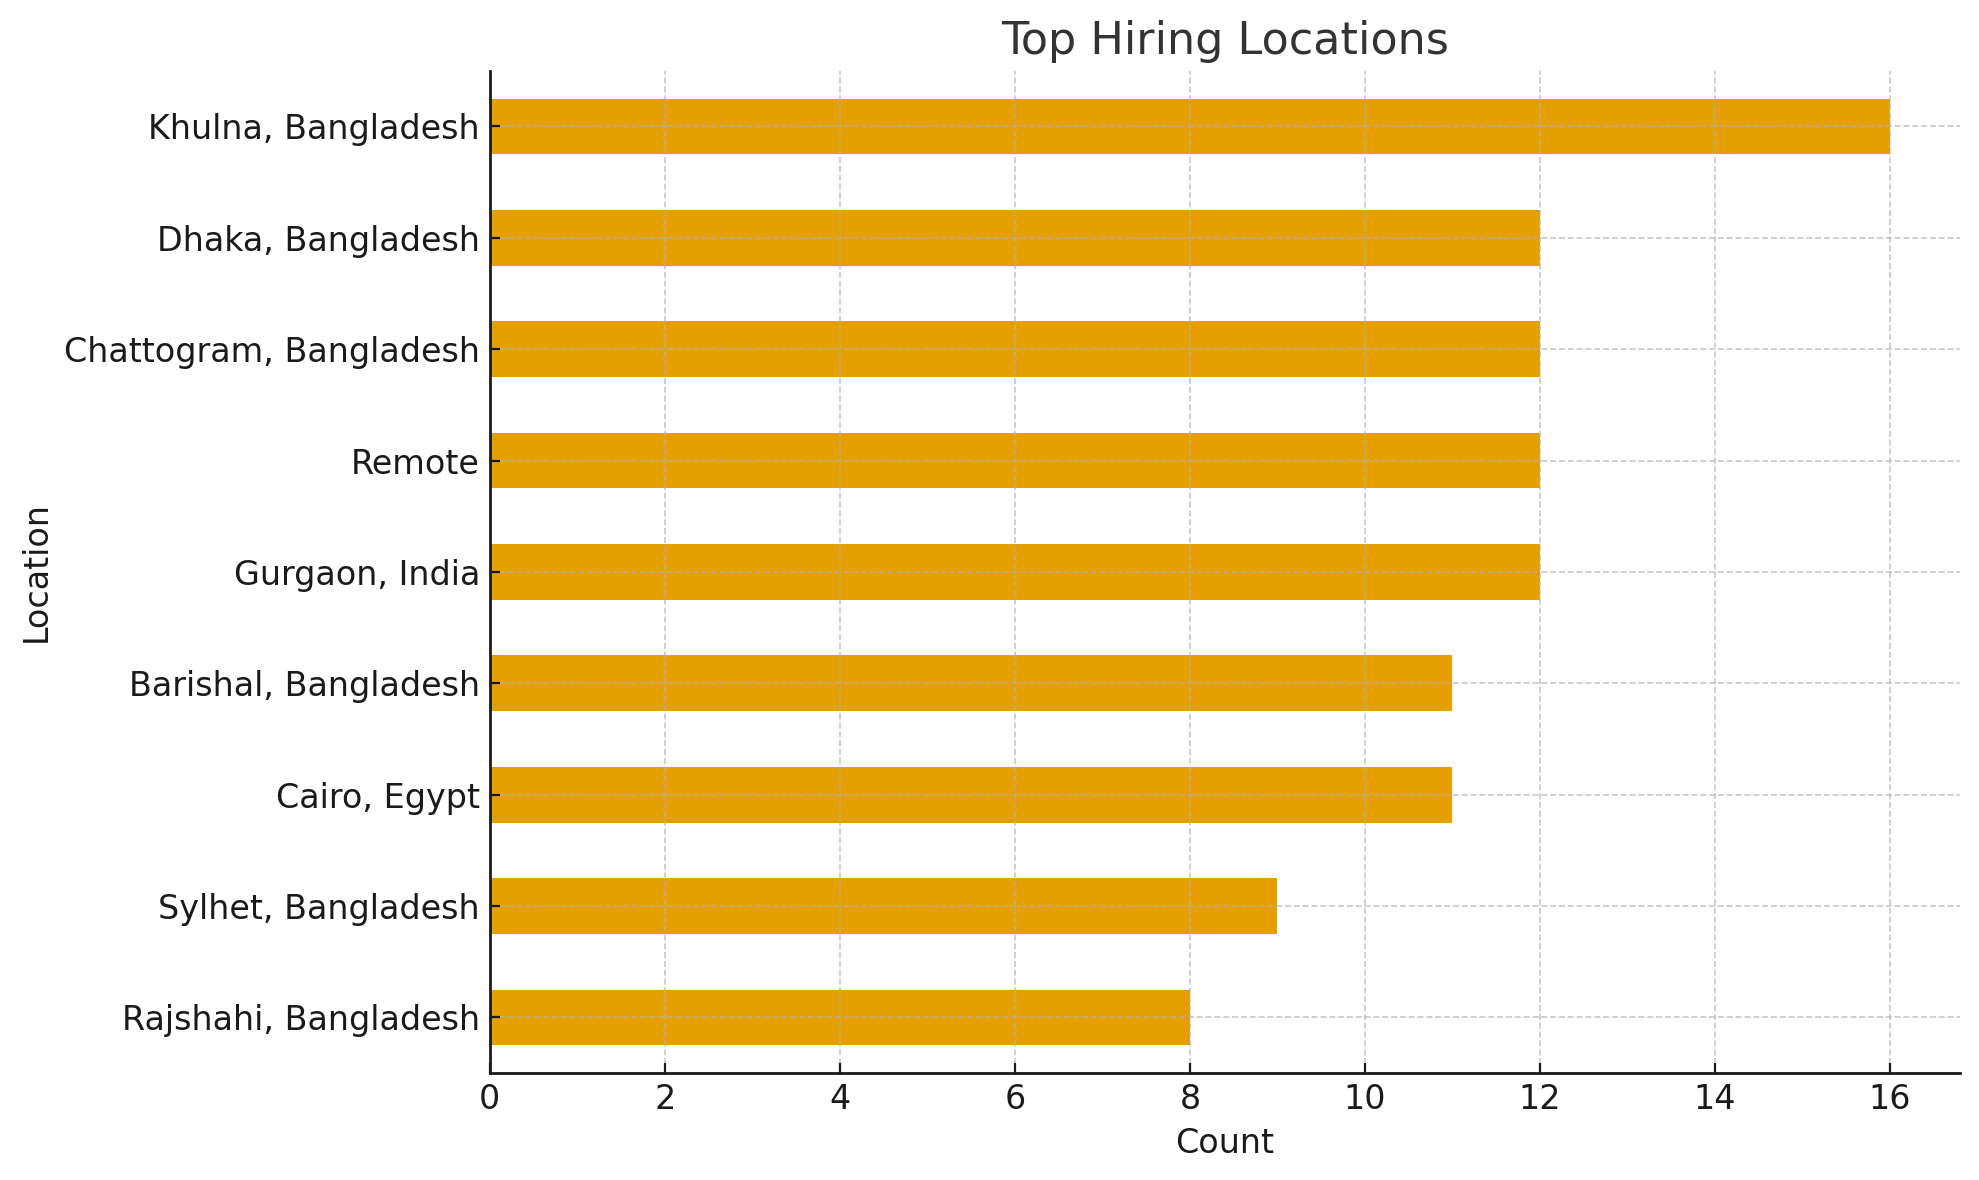

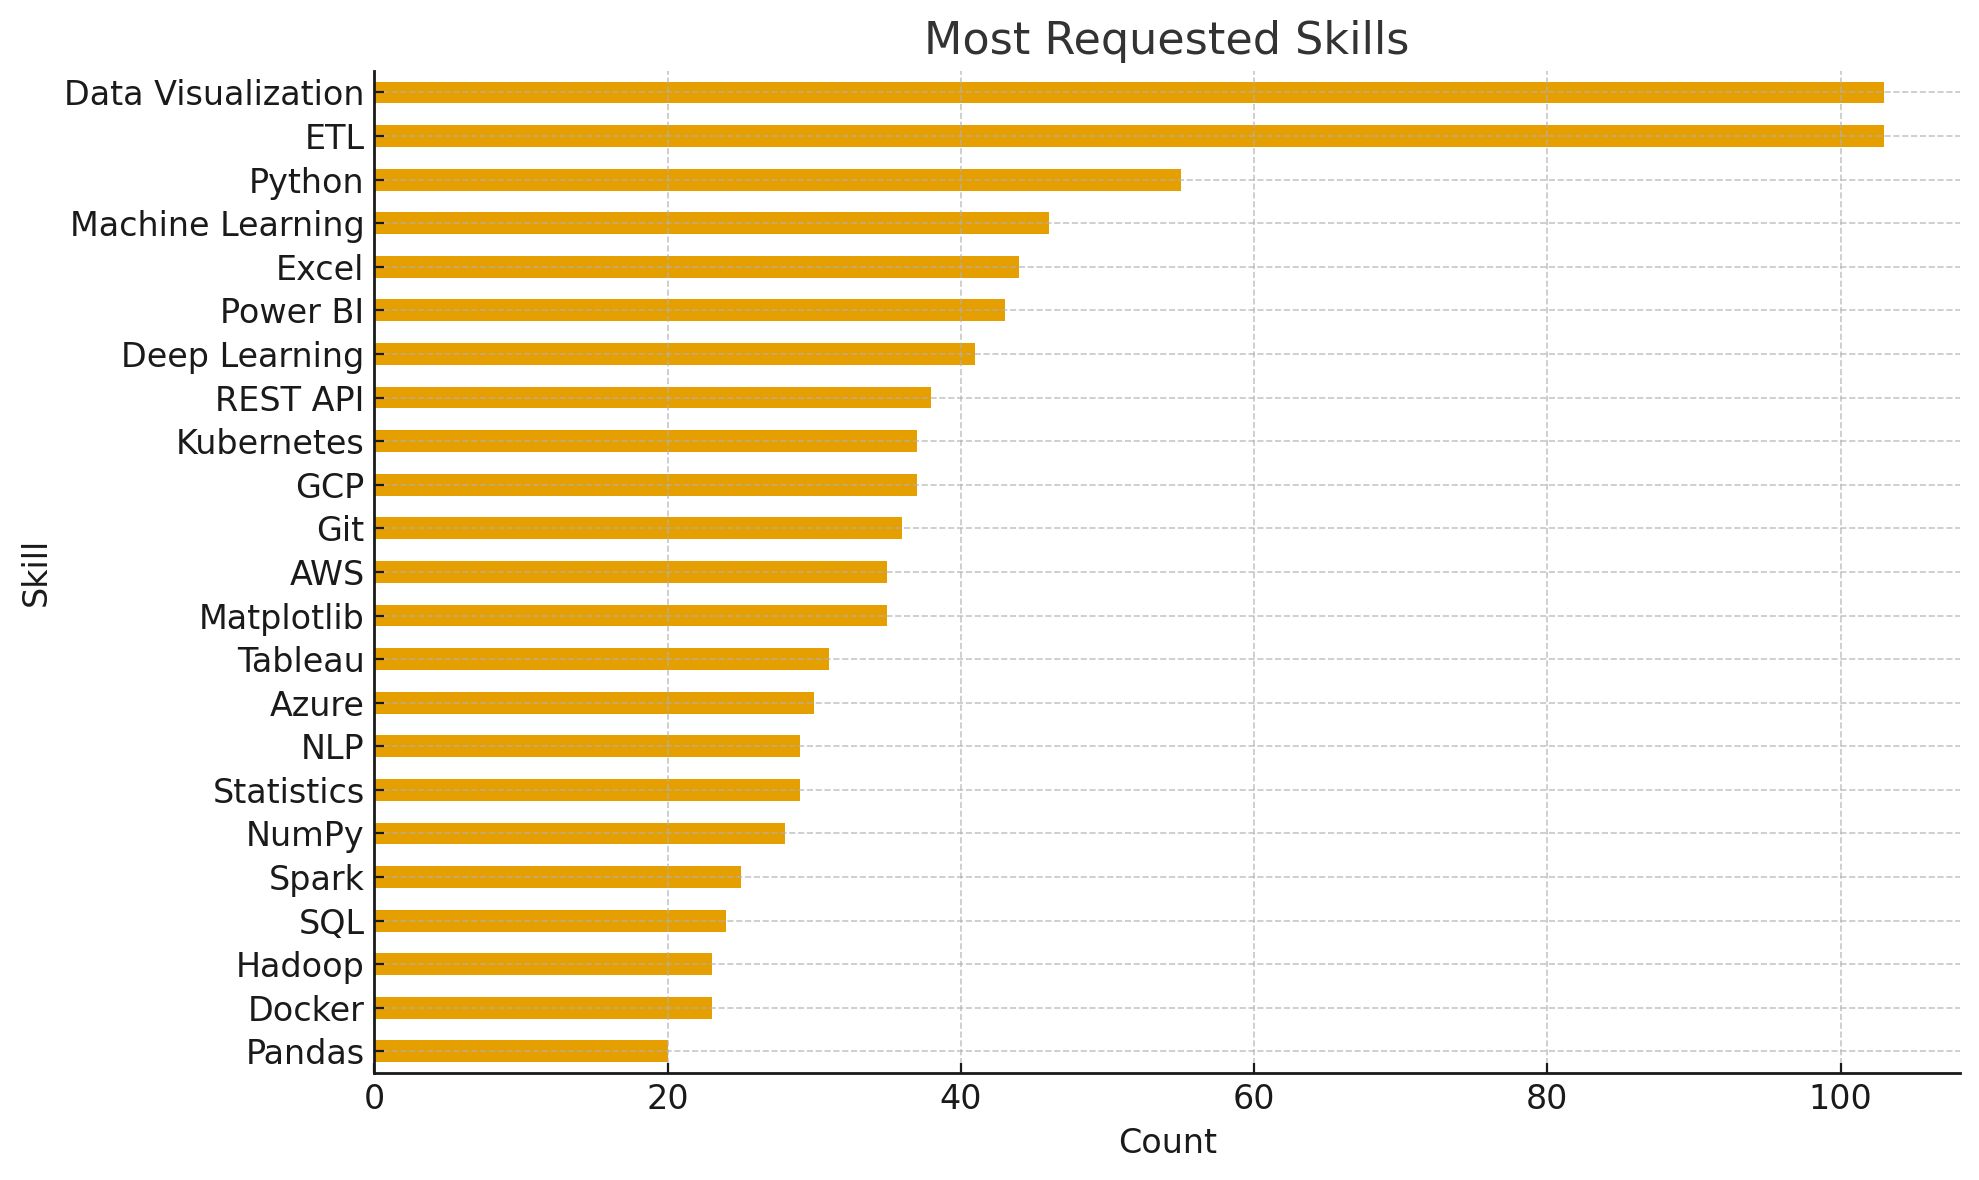

In [7]:

import os
os.makedirs(plots_dir, exist_ok=True)

def bar_plot(series, title, filename, xlabel, ylabel):
    plt.figure()
    series[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    out_path = os.path.join(plots_dir, filename)
    plt.savefig(out_path, dpi=180, bbox_inches="tight")
    plt.show()
    return out_path

plot_titles = bar_plot(top_titles, "Top Job Titles", "top_job_titles.png", "Count", "Title")
plot_locations = bar_plot(top_locations, "Top Hiring Locations", "top_locations.png", "Count", "Location")
plot_skills = bar_plot(top_skills, "Most Requested Skills", "top_skills.png", "Count", "Skill")


## 6. Bonus — Top Skills by City (Top 4 Cities)

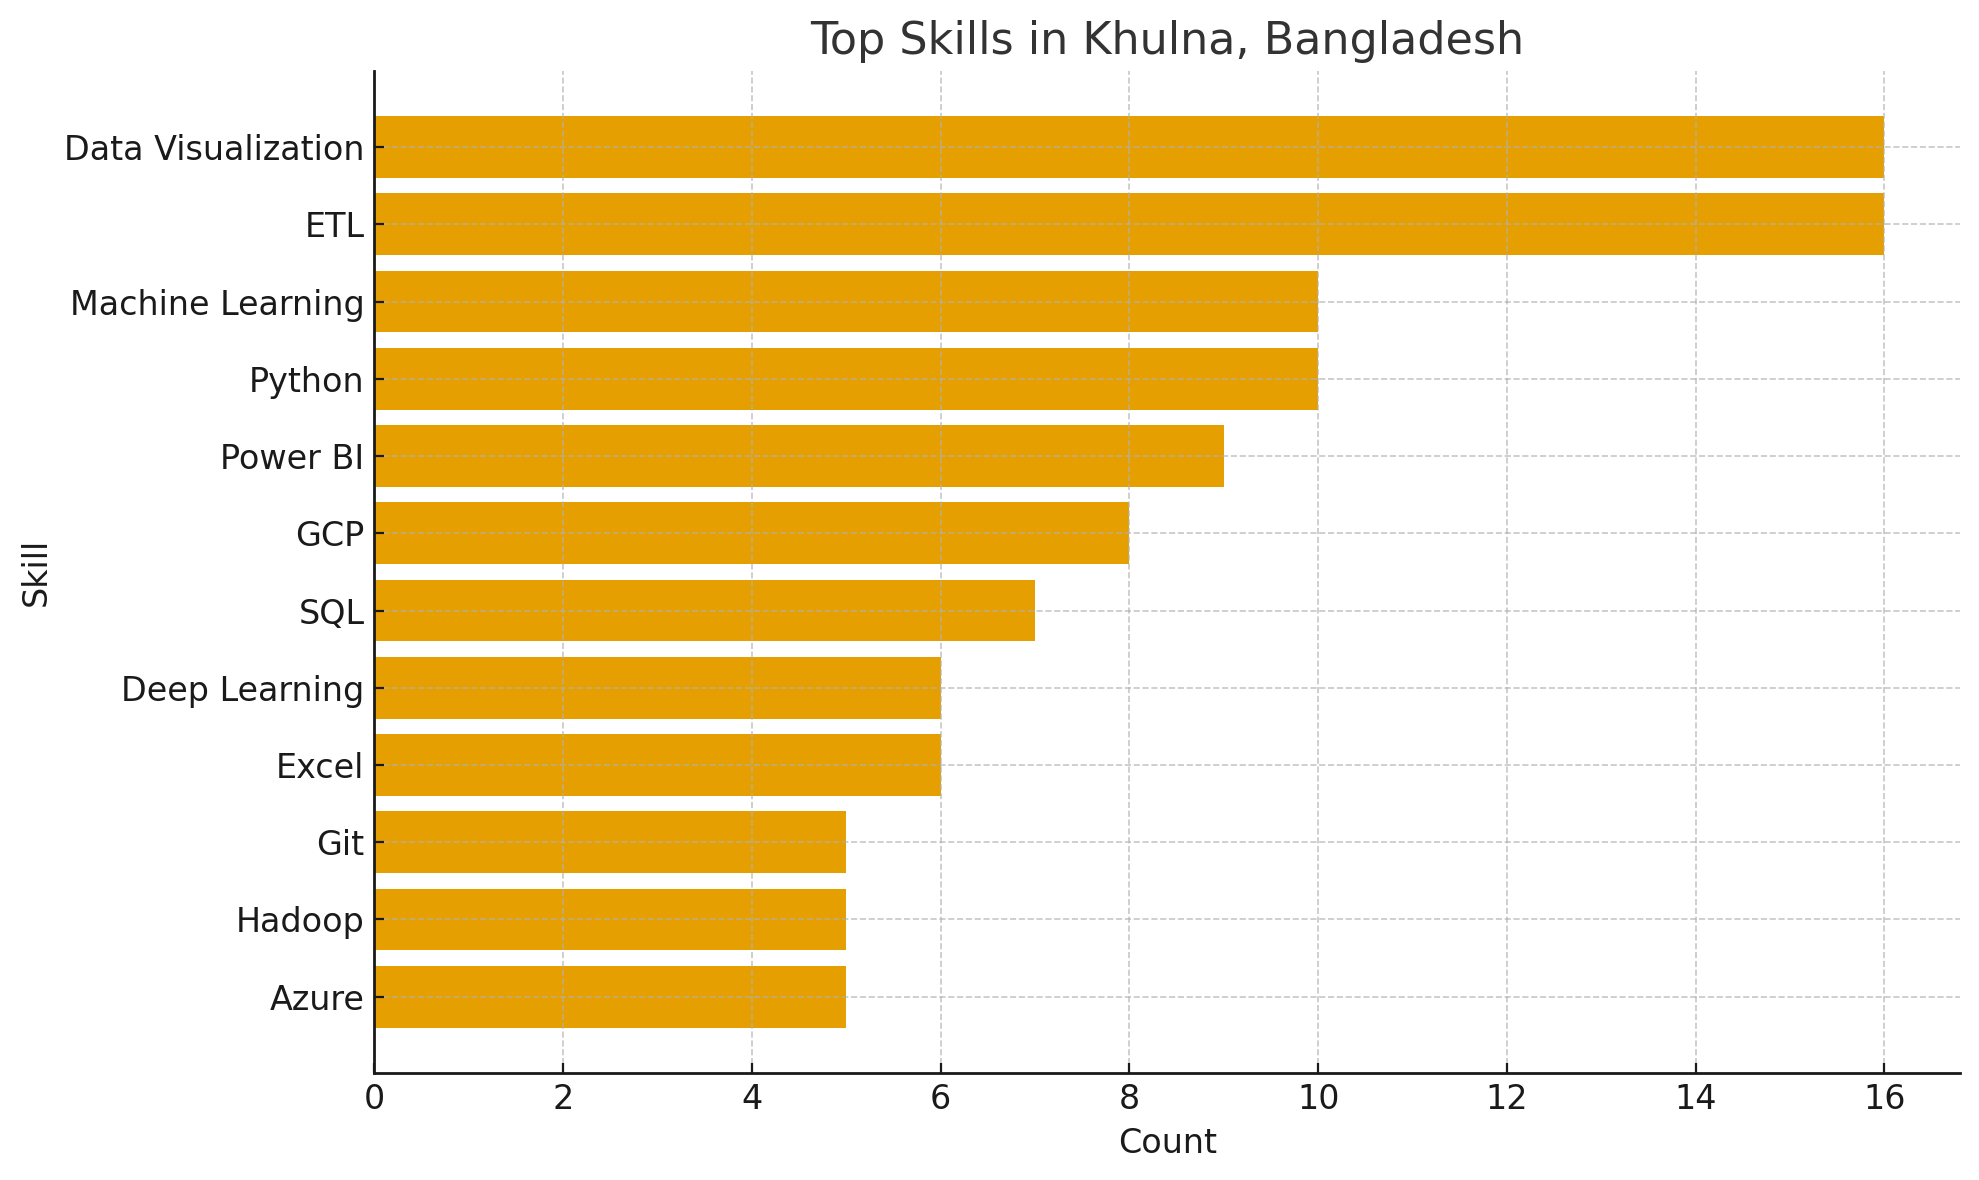

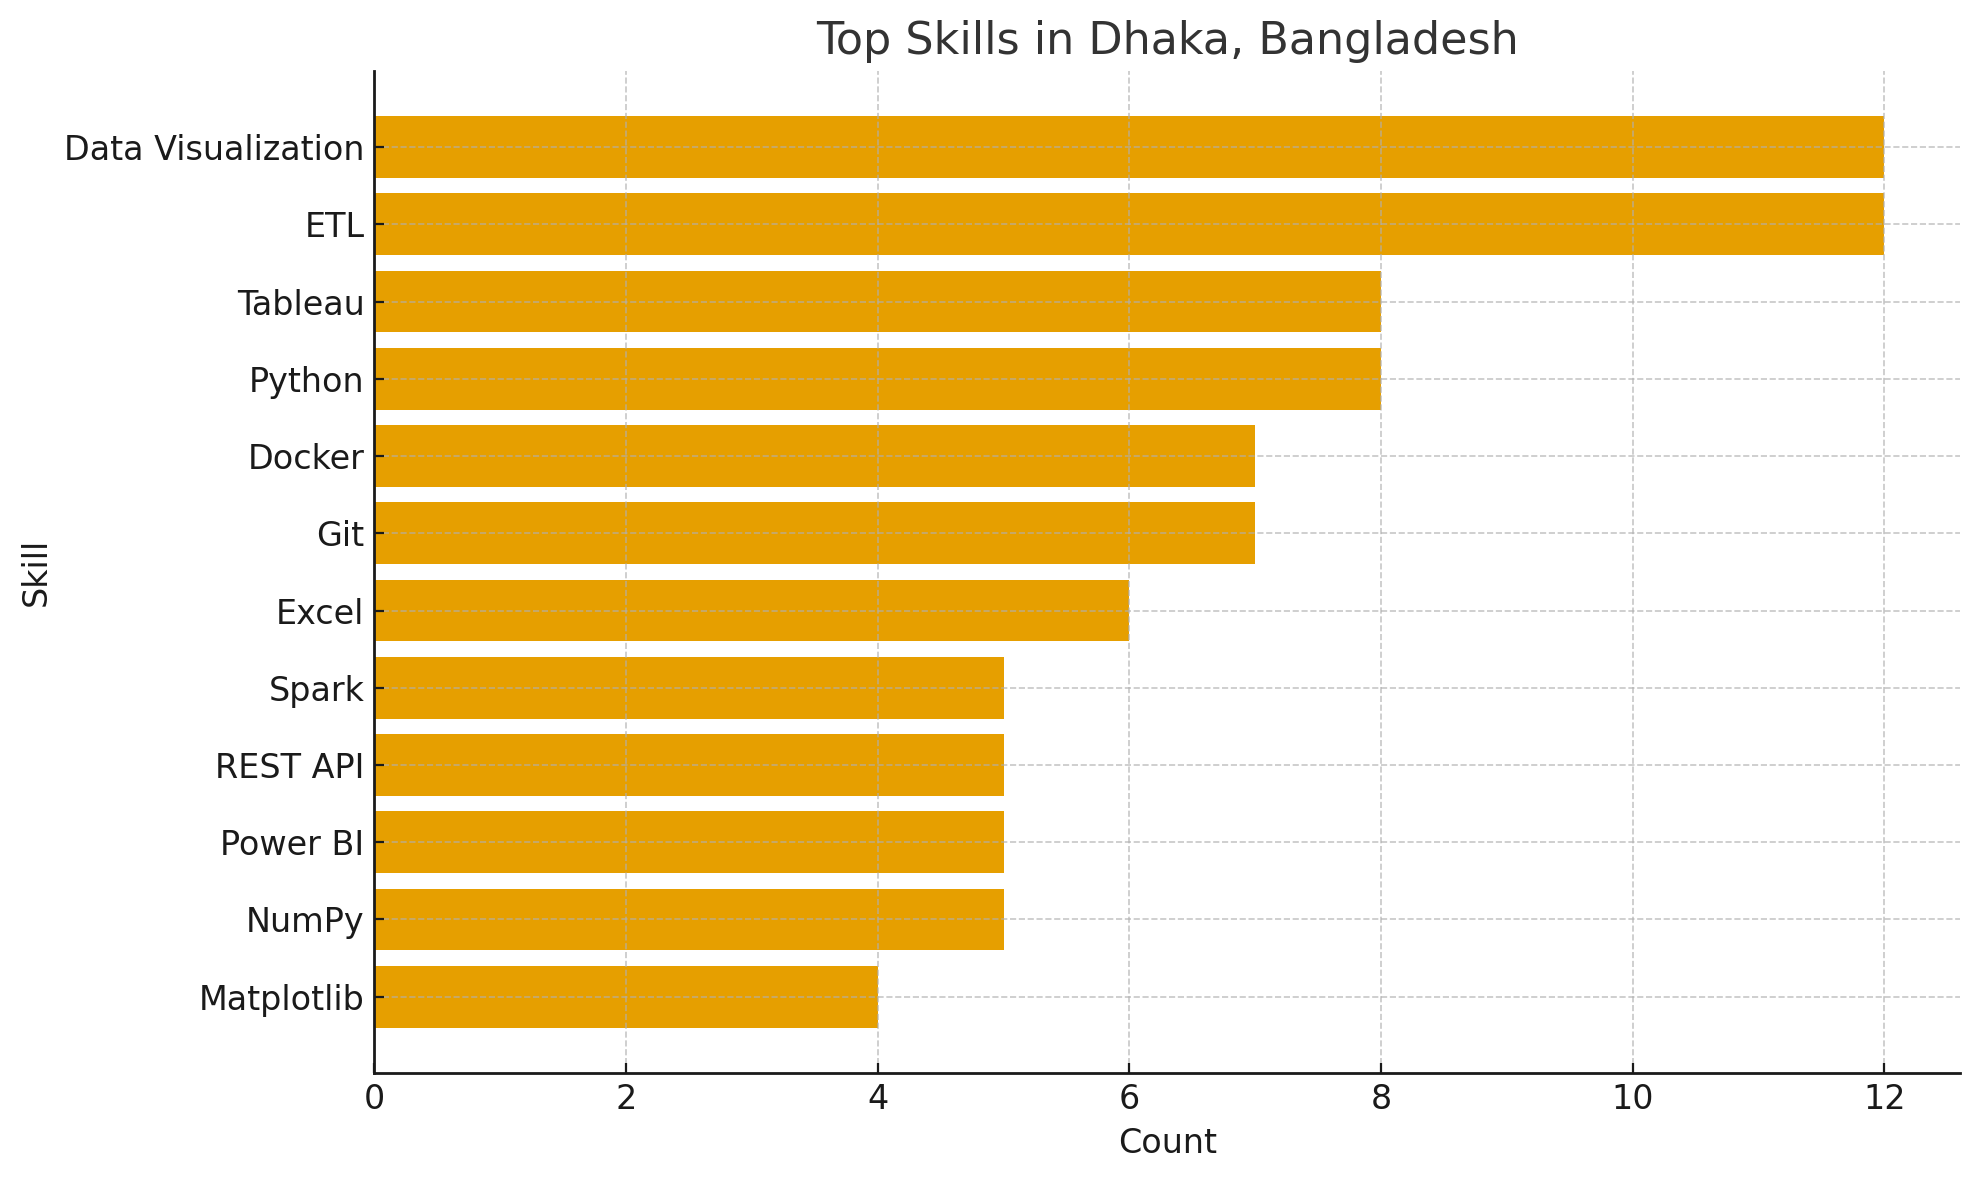

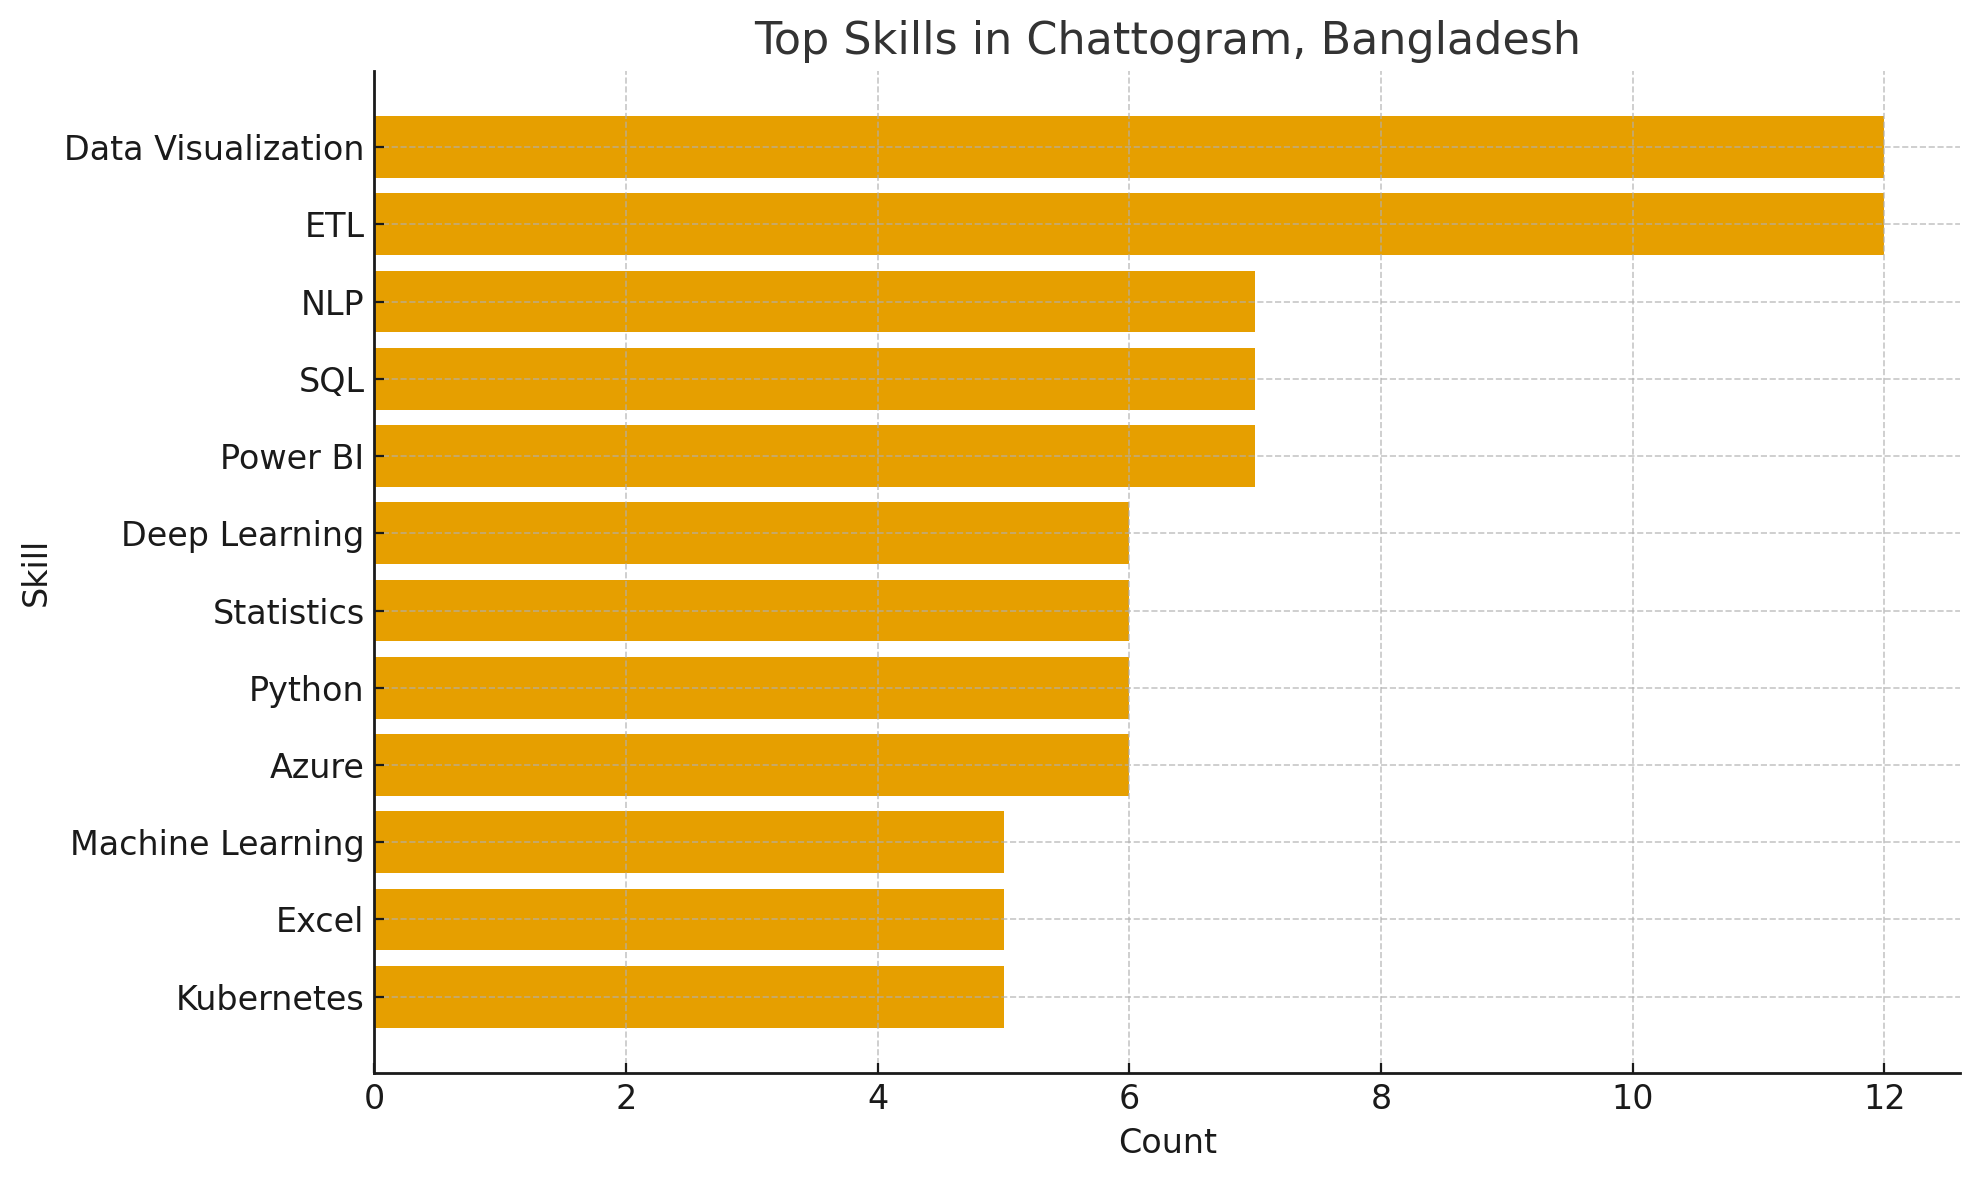

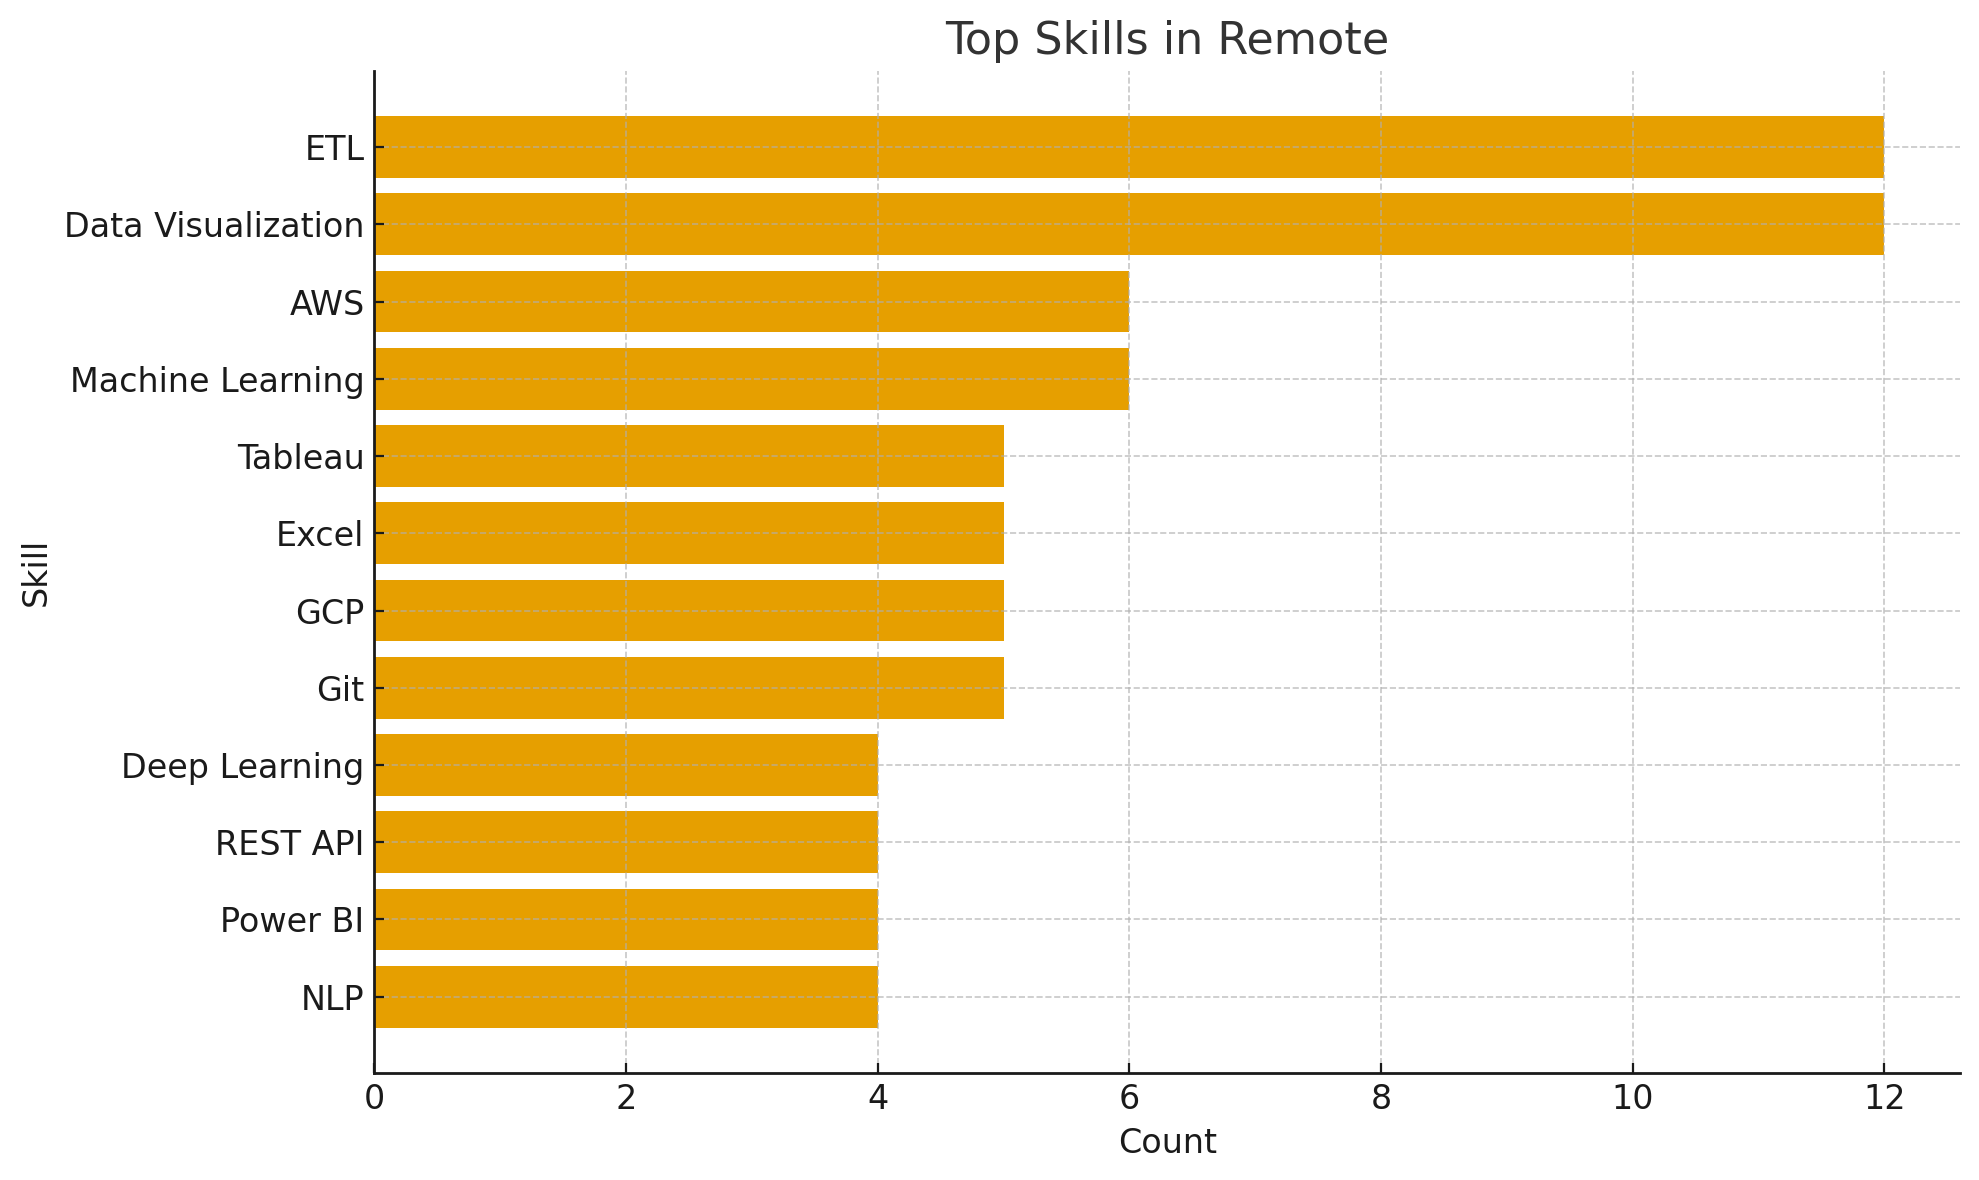

['/mnt/data/task6_webscraping_project/plots/skills_Khulna_Bangladesh.png',
 '/mnt/data/task6_webscraping_project/plots/skills_Dhaka_Bangladesh.png',
 '/mnt/data/task6_webscraping_project/plots/skills_Chattogram_Bangladesh.png',
 '/mnt/data/task6_webscraping_project/plots/skills_Remote.png']

In [8]:

top_cities = df["location"].value_counts().head(4).index.tolist()
skills_by_city = (exploded[exploded["location"].isin(top_cities)]
                  .groupby(["location","skills"]).size().reset_index(name="count"))

city_skill_plots = []
for city in top_cities:
    tmp = skills_by_city[skills_by_city["location"]==city].sort_values("count", ascending=False).head(12)
    plt.figure()
    plt.barh(tmp["skills"][::-1], tmp["count"][::-1])
    plt.title(f"Top Skills in {city}")
    plt.xlabel("Count")
    plt.ylabel("Skill")
    plt.tight_layout()
    cpath = os.path.join(plots_dir, f"skills_{city.replace(', ','_').replace(' ','_')}.png")
    plt.savefig(cpath, dpi=180, bbox_inches="tight")
    plt.show()
    city_skill_plots.append(cpath)

city_skill_plots


## 7. Save Cleaned Dataset

In [9]:

csv_path = os.path.join(base_dir, "cleaned_job_postings.csv")
df.to_csv(csv_path, index=False)
csv_path


'/mnt/data/task6_webscraping_project/cleaned_job_postings.csv'

## 8. Key Insights (from this snapshot)

In [ ]:

print("Total unique postings:", len(df))
print("Top role:", top_titles.index[0], "(", int(top_titles.iloc[0]), ")")
print("Top location:", top_locations.index[0], "(", int(top_locations.iloc[0]), ")")
print("Top skill:", top_skills.index[0], "(", int(top_skills.iloc[0]), ")")


### Key Insights Summary

- **Total postings** → number of unique job ads after cleaning.  
- **Top role** → most frequently advertised job title.  
- **Top location** → city/region with the highest demand.  
- **Top skill** → single most requested skill across all postings.  

This gives a quick **snapshot of the job market demand** from the dataset.  
